# Demo of consensus clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from consensus_clustering.load_data import load_fuzzy_data
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
# from scipy.spatial import distance
# from copy import deepcopy
# from timeit import default_timer as timer
# from datetime import timedelta
# import importlib
%matplotlib inline

## Use of consensus class

In [2]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

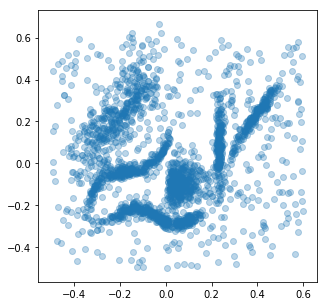

In [3]:
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1],alpha=.3)

#### Fit some other clustering methods...

Detected 6 clusters
Finished after 0:00:00.270936
Rate of noise in dataset: 0.187960


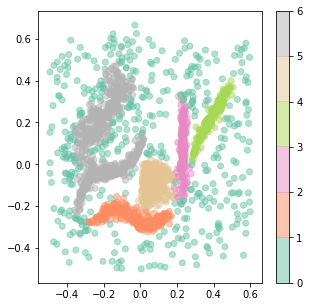

In [4]:
data = fuzzy
eps = 0.03
minPts = 10

# Fit
dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts)
dbscan_obj.fit()
labels = dbscan_obj.cluster_labels
for i in range(len(labels)):
    if labels[i] == 'noise':
        labels[i] = 0

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(data[:,0], data[:,1], c=labels, cmap=plt.get_cmap('Set2', dbscan_obj._n_clusters), alpha=.5)
plt.colorbar()

terminated by break condition
20 iterations until termination.
Finished after 0:00:00.077766
max within-cluster distance to center: 0.353391
mean within-cluster distance to center: 0.090265
sum of within cluster squared errors: 25.963935


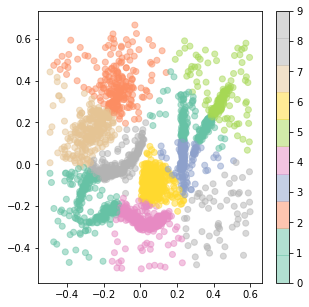

In [5]:
data = fuzzy
k = 10

# Fit
kmeans_obj = cl_dist.KMeans(data, k)
kmeans_obj.fit()
labels = kmeans_obj.cluster_labels

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(data[:,0], data[:,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
22 iterations until termination.
Finished after 0:00:00.066318
max within-cluster distance to center: 0.364820
mean within-cluster distance to center: 0.041219
sum of within cluster squared errors: 7.265106
KMeans terminated. 

Finished after 0:02:25.756287


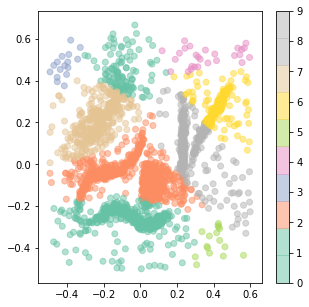

In [6]:
data = fuzzy
k = 10
bandwidth = 0.1

# Fit
spectral_obj = similarity.SpectralClustering(data, k=k, bandwidth=bandwidth)
spectral_obj.fit()
labels = spectral_obj.cluster_labels

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

#### ...and fit consensus

Hierarchical clustering terminated.
Finished after 0:00:49.007115
Stopping cluster number was reached.
Current number of clusters: 8
Current minimum cluster distance: 0.66
Consensus clustering terminated.
Finished after 0:00:50.634687
ANMI (average normalized mutual information) of consensus with clusterings: 0.776


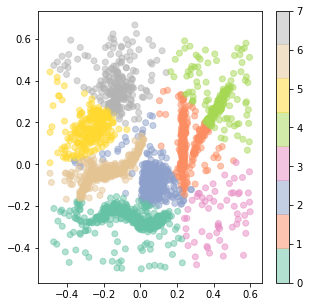

In [7]:
data = fuzzy
n = len(data)
clusterings = [spectral_obj, kmeans_obj, dbscan_obj]
recluster_what = 'points'
how = 'hierarchical'
k = 8

# Fit
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how)
consensus_obj.fit()
labels = consensus_obj.cluster_labels

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

## Strength of consensus clustering

#### Choose dataset - KMeans performs well on uneven blobs, DBSCAN on spirals

In [8]:
from consensus_clustering.load_data import load_spiral_data, scale_data, load_uneven_blobs
data = load_spiral_data(scale = 'True')
#data = load_uneven_blobs()

Fit some KMeans and DBSCAN objects

In [9]:
no_labels = [0] * len(data)
num_objects = 5
dbscan_objects = [None] * num_objects
kmeans_objects = [None] * num_objects
dbscan_obj = None
kmeans_obj = None

# Fit some DBSCAN objects
eps_array = np.linspace(0.5, 1.5, num_objects)
minPts_start = 5
minPts_array = np.arange(minPts_start, minPts_start + num_objects)
for i, (eps, minPts) in enumerate(zip(eps_array, minPts_array)):
    dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
    dbscan_obj.fit()
    dbscan_objects[i] = dbscan_obj

# Fit some KMeans objects
num_clusters_start = 2
num_clusters_array = np.arange(num_clusters_start, num_clusters_start + num_objects)
for i, k in enumerate(num_clusters_array):
    kmeans_obj = cl_dist.KMeans(data, k=k, verbose=False)
    kmeans_obj.fit()
    kmeans_objects[i] = kmeans_obj

Find a consensus

In [10]:
clusterings = [*kmeans_objects, *dbscan_objects]
recluster_what = 'points'
how = 'hierarchical'
k=3

# Fit consensus
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how, verbose=False)
consensus_labels = consensus_obj.cluster_labels

C:\Users\Johannes\Desktop\Uni\Clustering-Paper\consensus_clustering\consensus_clustering\consensus.py:202: RuntimeWarning: invalid value encountered in double_scalars
  return mutual_information / np.sqrt(entropy_a * entropy_b)


Plot results

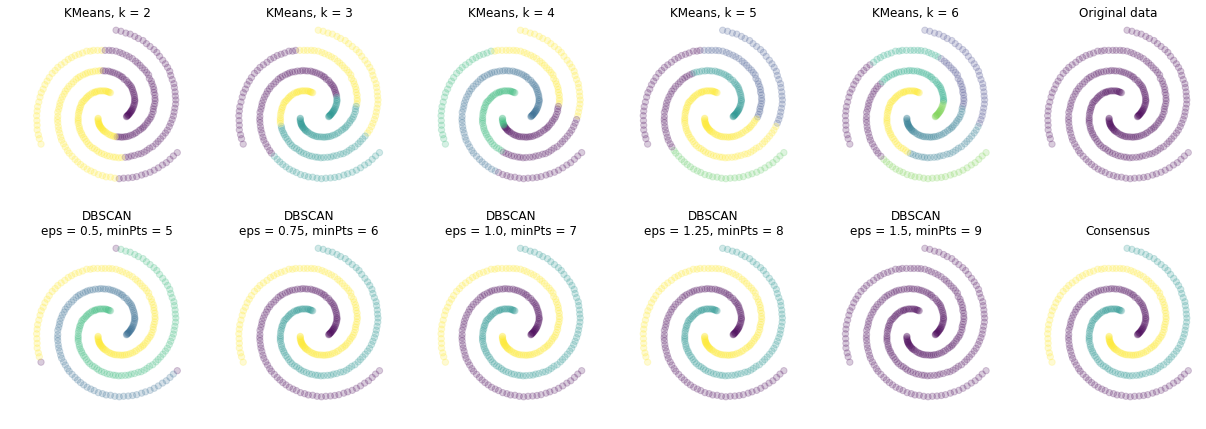

In [11]:
# Put labels in right order in to the labels array
labels = []
for obj in kmeans_objects:
    labels.append(obj.cluster_labels)
labels.append(no_labels)
for obj in dbscan_objects:
    labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
labels.append(consensus_labels)

# Init plotting arrangement
num_plots = len(kmeans_objects) + len(dbscan_objects) + 2
num_subplts_per_row = 6
num_rows = num_plots // num_subplts_per_row
num_cols = min(num_subplts_per_row, num_plots)
f, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

# Plot labels
for i, ax in enumerate(axarr.flat):
    #format_square(ax, min(data[:, 0]), max(data[:, 0]), min(data[:, 1]), max(data[:, 1]))
    ax.set_aspect('equal')
    ax.scatter(data[:, 0], data[:, 1], s=40, c=labels[i], alpha=0.2)
    ax.axis('off')
    if i < num_subplts_per_row - 1:
        ax.set_title('KMeans, k = {0}'.format(num_clusters_array[i]))
    elif i == num_subplts_per_row - 1:
        ax.set_title('Original data')
    elif i < num_plots - 1:
        ax.set_title('DBSCAN\neps = {0}, minPts = {1}'.format(eps_array[i-num_subplts_per_row], minPts_array[i-num_subplts_per_row]))
    else:
        ax.set_title('Consensus')
plt.tight_layout()
plt.show()

## Parameter search with consensus clustering

In [12]:
def param_search_dbscan(data, k_consensus, recluster_what, recluster_how, eps_arr, min_pts_arr):
    num_objects = len(eps_arr)
    dbscan_objects = [None] * num_objects
    dbscan_obj = None

    print("Fit DBSCAN objects")

    # Fit DBSCAN objects
    for i, (eps, minPts) in enumerate(zip(eps_arr, min_pts_arr)):
        dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
        dbscan_obj.fit()
        dbscan_objects[i] = dbscan_obj

    print("Fit consensus")

    # Fit consensus
    clusterings = [*dbscan_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(dbscan_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, dbscan_objects, consensus_obj

Set parameters

In [13]:
# General
data = fuzzy
k_consensus = 10
recluster_what = 'points'
recluster_how = 'spectral'
num_objects = 10

# DBSCAN
eps_arr = np.linspace(0.01, 0.05, num_objects)
min_pts = 10
min_pts_arr = np.ones(num_objects).astype(int) * min_pts

In [14]:
nmi_arr, cl_objects, consensus_obj = param_search_dbscan(
    data = fuzzy,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = eps_arr,
    min_pts_arr = min_pts_arr)

Fit DBSCAN objects
Fit consensus
Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
2 iterations until termination.
Finished after 0:00:00.037145
max within-cluster distance to center: 160.959246
mean within-cluster distance to center: 86.564117
sum of within cluster squared errors: 19240230.201757
KMeans terminated. 

Finished after 0:02:14.614786
Consensus clustering terminated.
Finished after 0:02:19.926972
ANMI (average normalized mutual information) of consensus with clusterings: 0.5
Calculate NMI's


Plot

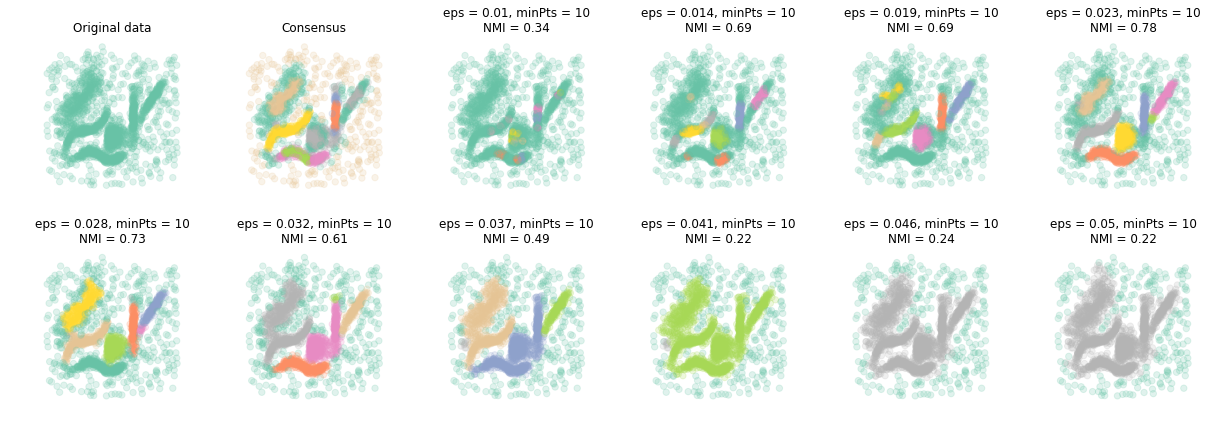

In [15]:
# Put labels in right order in to the labels array
labels = []
no_labels = [0] * len(data)
labels.append(no_labels)
labels.append(consensus_obj.cluster_labels)
for i in range(num_objects):
    labels.append(consensus_obj._noise_to_zero(cl_objects[i]).cluster_labels)

# Init plotting arrangement
num_plots = len(cl_objects) + 2
num_subplts_per_row = 6
num_rows = num_plots // num_subplts_per_row
num_cols = min(num_subplts_per_row, num_plots)
f, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

# Plot labels
for i, ax in enumerate(axarr.flat):
    ax.set_aspect('equal')
    ax.scatter(data[:, 0], data[:, 1], s=40, c=labels[i], cmap='Set2', alpha=0.2)
    ax.axis('off')
    if i==0:
        ax.set_title('Original data')
    elif i==1:
        ax.set_title('Consensus')
    else:
        ax.set_title('eps = {:.2}, minPts = {:}\nNMI = {:.2}'.format(eps_arr[i-2], min_pts_arr[i-2], nmi_arr[i-2]))
        
plt.tight_layout()
plt.show()